# Assignment 2
**Authors:**
- **Student 1:**  Michele Carusone, michele.carusone@studio.unibo.it
- **Student 2:**  Norberto Casarin, norberto.casarin@studio.unibo.it
- **Student 3:**  Antonio Gravina, antonio.gravina@studio.unibo.it
- **Student 4:**  Gabriele Nanni, gabriele.nanni4@studio.unibo.it

### Huggingface Login

First of all, we need to login to Huggingface in order to be able to use the models.

In [1]:
import os
from huggingface_hub import login




token = os.getenv("HUGGINGFACE_TOKEN")

login(token)

### Imports

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

PATH = 'data/'

### Data Loading
We cast the csv file into a pandas dataframe.

In [3]:
df = pd.read_csv(PATH + 'a2_test.csv')
df.head()

,rewire_id,text,label_sexist
0,sexism2022_english-17133,The boys must be gaming because there goes the...,not sexist
1,sexism2022_english-14197,Look at those eyes. Either someone unexpectedl...,sexist
2,sexism2022_english-3018,Old man mogs everyone in this sub,not sexist
3,sexism2022_english-5301,"Excellent, I was just looking at another post ...",not sexist
4,sexism2022_english-17796,So you run back to daddy whenever you need hel...,sexist


---

# [Task 1 - 0.5 points] Model setup

Once the test data has been loaded, we have to setup the model pipeline for inference.

In particular, we have to:
- Load the model weights from Huggingface
- Quantize the model to fit into a single-GPU limited hardware

## Phi-3.5 mini instruct

The first model we use is `microsoft/Phi-3.5-mini-instruct`. This model has 4B parameters and is a smaller version of the Phi-3.5 model. It is a model for text generation and completion. We are using the instruct version, which is a version of the model that has been fine-tuned on a dataset of instructions.

In [4]:
model_card = "microsoft/Phi-3.5-mini-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_card, trust_remote_code=True)

We define the configuration for the quantization of the model. In particular, we want to use the 4bit quantization, which is the most aggressive one. In this way, we can reduce the model size and make it fit into a single GPU.

We also load the model from Huggingface and pass the configuration defined before.

In [5]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_card,
    return_dict=True,
    quantization_config=bnb_config,
    device_map = "auto",
    trust_remote_code=True,
)

model.to("cuda")

`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear4bit(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear4bit(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_fe

We set the configuration generation parameters for the model. In particular, we set the maximum length of the generated text to 2 tokens. 

Moreover, we put the parameter `do_sample` to `False` in order to generate the text with greedy decoding, making the generation faster and with deterministic results.

In [6]:
generation_config = model.generation_config
generation_config.max_new_tokens = 2
generation_config.do_sample = False
generation_config.temperature = None
generation_config.top_p = None

We check the memory usage of the model so that we can verify that the model fits into the GPU memory.

In [7]:
gpu_name = torch.cuda.get_device_name(0)
print(f"GPU: {gpu_name}")

total_memory = torch.cuda.get_device_properties(0).total_memory
print(f"Total GPU memory: {total_memory / (1024 ** 3):.2f} GB")

allocated_memory = torch.cuda.memory_allocated(0)
print(f"Allocated GPU memory: {allocated_memory / (1024 ** 3):.2f} GB")

GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Total GPU memory: 8.00 GB
Allocated GPU memory: 2.11 GB


Now that we have the model ready and we made sure that it fits into the GPU memory, we can move on to the next task.

---

# [Task 2 - 1.0 points] Prompt setup

Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


The prompt that we need to use is the following.

In [8]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

As we can see, the prompt requires a `text` field, which is the input text that we'll take from the dataset.

We use Hugging Face custom handling function on the prompt to create our final template. For this reason, we'll use the function `apply_chat_template` of the tokenizer. We set `add_generation_prompt` to `True` in order to add a token that indicates the start of a response generation.

In [9]:
prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)

We can check the prompt on an example chosen from the dataset.

In [10]:
example_text = "Ahahahah I fucking hate women. They are so stupid."
formatted_example = prompt.format(text=example_text)
parsed_example = tokenizer(formatted_example, return_tensors='pt').to('cuda')
generated = model.generate(input_ids=parsed_example['input_ids'],
                           attention_mask=parsed_example['attention_mask'],
                           generation_config=generation_config,
                           do_sample=False)
output = tokenizer.batch_decode(generated, skip_special_tokens=True)[0]
print(output)

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
You are not running the flash-attention implementation, expect numerical differences.


You are an annotator for sexism detection. Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        Ahahahah I fucking hate women. They are so stupid.

        ANSWER:
         YES


We then write a function that takes the input texts and the prompt template, as well as the tokenizer. It returns a list of tokenized prompts that can be used to generate the responses.

In [11]:
def prepare_prompts(texts, prompt_template, tokenizer):
    """
      This function format input text samples into instructions prompts.

      Inputs:
        texts: input texts to classify via prompting
        prompt_template: the prompt template provided in this assignment
        tokenizer: the transformers Tokenizer object instance associated with the chosen model card

      Outputs:
        input texts to classify in the form of instruction prompts
    """
    tokenized_prompts = []

    for text in texts:
        full_prompt = prompt_template.format(text=text)
        tokenized_prompt = tokenizer(full_prompt, return_tensors='pt').to('cuda')
        tokenized_prompts.append(tokenized_prompt)

    return tokenized_prompts

---

# [Task 3 - 1.0 points] Inference

We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

We first define the function `generate_response` that takes the model and the tokenized prompts and returns the generated responses (decoded).

In [12]:
def generate_responses(model, prompt_examples):
    """
      This function implements the inference loop for a LLM model.
      Given a set of examples, the model is tasked to generate a response.

      Inputs:
        model: LLM model instance for prompting
        prompt_examples: pre-processed text samples

      Outputs:
        generated responses
    """
    responses = []

    for prompt in prompt_examples:
      outputs = model.generate(**prompt, max_new_tokens=1)
      response = tokenizer.decode(outputs[0], skip_special_tokens=True)
      responses.append(response)

    return responses

The maximum number of tokens for the output is set to 1. With other models that we've experimented with, we have seen that this number should be slightly higher, because the model does not directly generate "YES" or "NO" tokens, but rather generates other tokens that are not needed. However, with this model, we've seen that this number works well.

Now we define `prompt_responses`, used for the extraction of the label from the textual response of the model. Note that this function can also return -1, which means that the model did not generate "YES" or "NO". This is useful for the computation of the fail ratio.

In [13]:
def process_response(response):
    """
      This function takes a textual response generated by the LLM
      and processes it to map the response to a binary label.

      Inputs:
        response: generated response from LLM

      Outputs:
        parsed binary response: return 1 if YES and 0 if NO
    """
    result = response.split("\n")[-1].strip().lower()
    if "yes" in result:
        return 1
    elif "no" in result:
        return 0
    else:
        return -1 # Invalid response, it will then casted to 0 for accuracy calculation. It is used for the fail rate calculation.

We can now run the inference loop on the dataset with `run_inference`.

In [14]:
def run_inference(df, model, prompt, tokenizer):
    """
    This function runs inference on a dataset using the LLM model.

    Inputs:
        df: input dataset
        model: LLM model instance for prompting
        prompt: the instruction prompt template
        tokenizer: the transformers Tokenizer object instance associated with the chosen model card

    Outputs:
        predictions: binary predictions for the input dataset
    """
    texts = df['text']
    tokenized_prompts = prepare_prompts(texts, prompt, tokenizer)
    print("Tokenized prompts generated.")
    responses = generate_responses(model, tokenized_prompts)
    print("Responses generated.")
    predictions = [process_response(response) for response in responses]
    print("Predictions generated.")

    return predictions

In [15]:
predictions = run_inference(df, model, prompt, tokenizer)
df['predictions_phi_zs'] = predictions

Tokenized prompts generated.
Responses generated.
Predictions generated.


---

# [Task 4 - 0.5 points] Metrics

In order to evaluate selected LLMs, we need to compute performance metrics.

In particular, we are interested in computing **accuracy** since the provided data is balanced with respect to classification classes.

Moreover, we want to compute the ratio of failed responses generated by models. 

That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.

We denote this metric as **fail-ratio**.

In summary, we parse generated responses as follows:
- 1 if the model says YES
- 0 if the model says NO
- 0 if the model does not answer in either way

We define the function `compute_metrics` that takes the list of responses and the list of true labels and returns the accuracy and the fail ratio, as a dictionary.

In [16]:
def compute_metrics(responses, y_true):
    """
      This function takes predicted and ground-truth labels and compute metrics.
      In particular, this function compute accuracy and fail-ratio metrics.
      This function internally invokes `process_response` to compute metrics.

      Inputs:
        responses: generated LLM responses
        y_true: ground-truth binary labels

      Outputs:
        dictionary containing desired metrics
    """
    accuracy = 0
    fail_ratio = 0

    for i, response in enumerate(responses):
        if response == y_true[i]:
            accuracy += 1
        elif response == -1 and y_true[i] == 0:
            accuracy += 1
        if response == -1:
            fail_ratio += 1
    
    accuracy /= len(y_true)
    fail_ratio /= len(y_true)

    return {
        "accuracy": round(accuracy, 4),
        "fail_ratio": round(fail_ratio, 4)
    }

We can finally compute the metrics on the dataset.

In [55]:
y_true = df['label_sexist'].apply(lambda x: 1 if x == 'sexist' else 0).tolist()
metrics_phi_zs = compute_metrics(df['predictions_phi_zs'], y_true)
print(metrics_phi_zs)

{'accuracy': 0.59, 'fail_ratio': 0.0}


We print the confusion matrix to see the distribution of the responses.

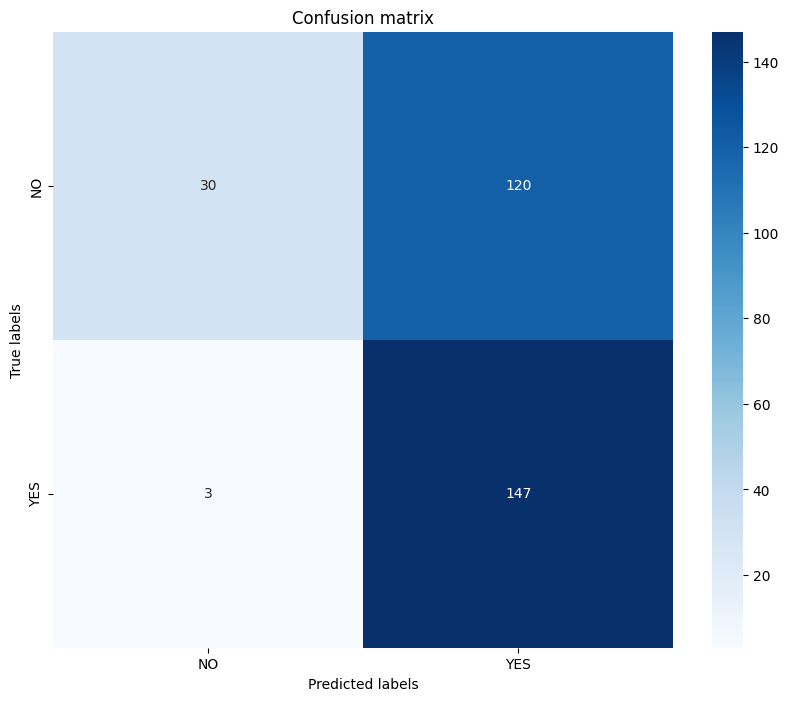

In [18]:
casted_predictions = df['predictions_phi_zs'].apply(lambda x: 0 if x == -1 else x)
conf_matrix = confusion_matrix(y_true=y_true, y_pred=casted_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

---

# [Task 5 - 1.0 points] Few-shot Inference

So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.

We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the prompt template as follows.

In [19]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

We load ``demonstrations.csv`` and encode it into a ``pandas.DataFrame`` object.


In [20]:
demonstrations = pd.read_csv(PATH + 'demonstrations.csv')
demonstrations.head()

,rewire_id,text,label_sexist
0,sexism2022_english-10348,I would never have my kid go to a daycare with...,not sexist
1,sexism2022_english-7950,Democrat women are so butt fucking ugly.,sexist
2,sexism2022_english-7742,If you really wanted to twist the knife you’d ...,not sexist
3,sexism2022_english-16170,Those women are pro-rape. They didn’t care abo...,sexist
4,sexism2022_english-9857,Married a bitch... Is it the standard scenario...,sexist


We define a ``build_few_shot_demonstrations`` function as the one reported below.

In [21]:
def build_few_shot_demonstrations(demonstrations, num_per_class=2):
    """
      Inputs:
        demonstrations: the pandas.DataFrame object wrapping demonstrations.csv
        num_per_class: number of demonstrations per class
  
      Outputs:
        a list of textual demonstrations to inject into the prompt template.
    """
    
    examples = []
    sexist_demonstrations = demonstrations[demonstrations['label_sexist'] == 'sexist']['text'].sample(num_per_class)
    non_sexist_demonstrations = demonstrations[demonstrations['label_sexist'] == 'not sexist']['text'].sample(num_per_class)
    examples.extend(sexist_demonstrations)
    examples.extend(non_sexist_demonstrations)

    for i in range(len(examples)):
        examples[i] =  f"TEXT: {examples[i]}\nANSWER: YES" if i < num_per_class else f"TEXT: {examples[i]}\nANSWER: NO"

    return examples

We first try with 2 examples per class. To make the results deterministic, we set the seed to `42`.

In [22]:
num_per_class = 2

np.random.seed(42)
examples = build_few_shot_demonstrations(demonstrations, num_per_class)
formatted_examples = "\n".join(examples)

We need to define a function named `prepare_prompts_few_shots` which follows the same logic of `prepare_prompts` but with the addition of the demonstration examples.

In [23]:
def prepare_prompts_few_shots(texts, examples, prompt_template, tokenizer):
    """
      This function format input text samples into instructions prompts.

      Inputs:
        texts: input texts to classify via prompting
        examples: list of examples to inject into the prompt template
        prompt_template: the prompt template provided in this assignment
        tokenizer: the transformers Tokenizer object instance associated with the chosen model card

      Outputs:
        input texts to classify in the form of instruction prompts
    """
    tokenized_prompts = []
    texts_len = len(texts)
    formatted_examples = "\n".join(examples)

    for i, text in enumerate(texts):
        full_prompt = prompt_template.format(text=text, examples=formatted_examples)
        tokenized_prompt = tokenizer(full_prompt, return_tensors='pt').to('cuda')
        tokenized_prompts.append(tokenized_prompt)

    return tokenized_prompts

We have all we need to run the few-shot inference loop on the dataset with `run_few_shot_inference`.

In [24]:
def run_inference_few_shots(df, model, prompt, tokenizer, num_per_class):
    """
    This function runs inference on a dataset using the LLM model.

    Inputs:
        df: input dataset
        model: LLM model instance for prompting
        prompt: the instruction prompt template
        tokenizer: the transformers Tokenizer object instance associated with the chosen model card
        num_per_class: number of examples for each class to inject into the prompt template

    Outputs:
        predictions: binary predictions for the input dataset
    """
    texts = df['text']
    examples = build_few_shot_demonstrations(demonstrations, num_per_class)
    tokenized_prompts = prepare_prompts_few_shots(texts, examples, prompt, tokenizer)
    print("Tokenized prompts generated.")
    responses = generate_responses(model, tokenized_prompts)
    print("Responses generated.")
    predictions = [process_response(response) for response in responses]
    print("Predictions generated.")

    return predictions

We then run the inference on the dataset, starting with 2 examples per classes

In [25]:
prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)
predictions = run_inference_few_shots(df, model, prompt, tokenizer, num_per_class)
df['predictions_phi_fs2'] = predictions

Tokenized prompts generated.
Responses generated.
Predictions generated.


Let's now check the metrics for the few-shot inference.

In [26]:
metrics_phi_fs2 = compute_metrics(df['predictions_phi_fs2'], y_true)
print(metrics_phi_fs2)

{'accuracy': 0.6467, 'fail_ratio': 0.0}


We can also print the confusion matrix to see how the model performs on each class.

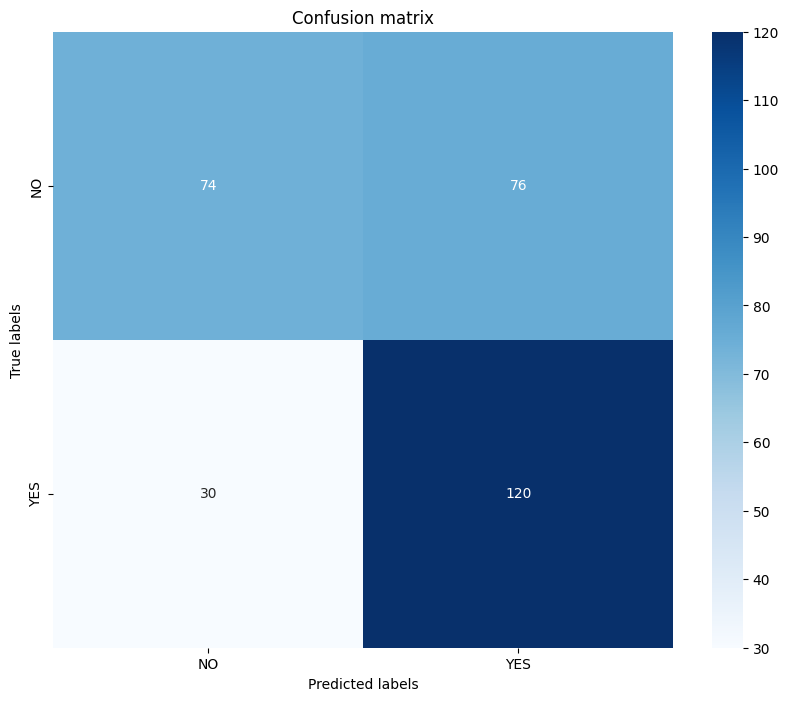

In [27]:
casted_predictions = df['predictions_phi_fs2'].apply(lambda x: 0 if x == -1 else x)
conf_matrix = confusion_matrix(y_true=y_true, y_pred=casted_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

As expected, the model performs better with few-shot prompting, as it has more information to generate the correct response. The fail ratio stays at 0.

We now test with 4 examples per class.

In [28]:
num_per_class = 4

np.random.seed(42)
examples = build_few_shot_demonstrations(demonstrations, num_per_class)

predictions = run_inference_few_shots(df, model, prompt, tokenizer, num_per_class)
df['predictions_phi_fs4'] = predictions

metrics_phi_fs4 = compute_metrics(df['predictions_phi_fs4'], y_true)
print(metrics_phi_fs4)

Tokenized prompts generated.
Responses generated.
Predictions generated.
{'accuracy': 0.6767, 'fail_ratio': 0.0}


We check check the confusion matrix.

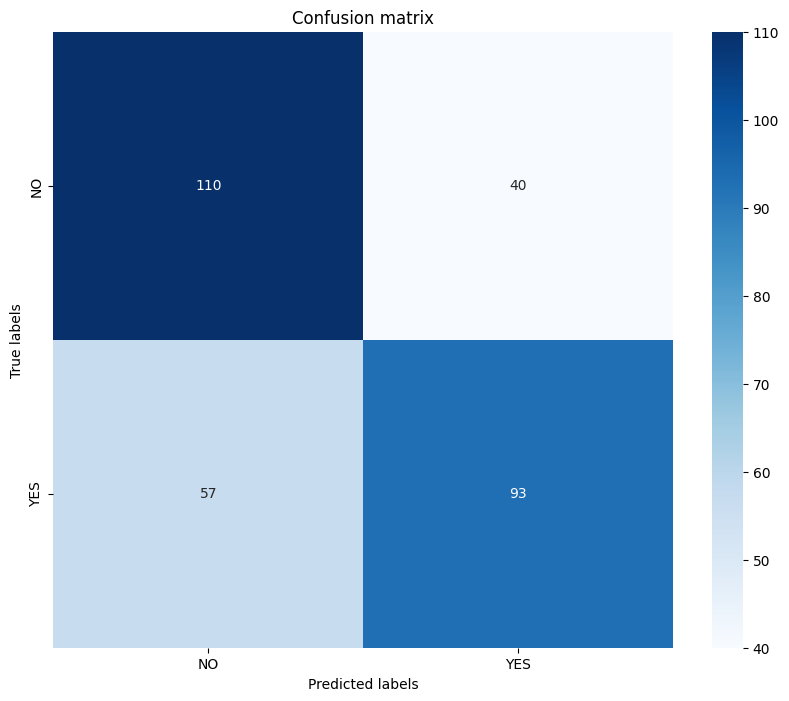

In [29]:
casted_predictions = df['predictions_phi_fs4'].apply(lambda x: 0 if x == -1 else x)
conf_matrix = confusion_matrix(y_true=y_true, y_pred=casted_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

The accuracy is even higher than before, as we are providing the model with more examples to learn from.

Finally, we test with 6 examples per class.

In [30]:
num_per_class = 6

np.random.seed(42)
examples = build_few_shot_demonstrations(demonstrations, num_per_class)

predictions = run_inference_few_shots(df, model, prompt, tokenizer, num_per_class)
df['predictions_phi_fs6'] = predictions

metrics_phi_fs6 = compute_metrics(df['predictions_phi_fs6'], y_true)
print(metrics_phi_fs6)

Tokenized prompts generated.
Responses generated.
Predictions generated.
{'accuracy': 0.6267, 'fail_ratio': 0.0}


We check the confusion matrix.

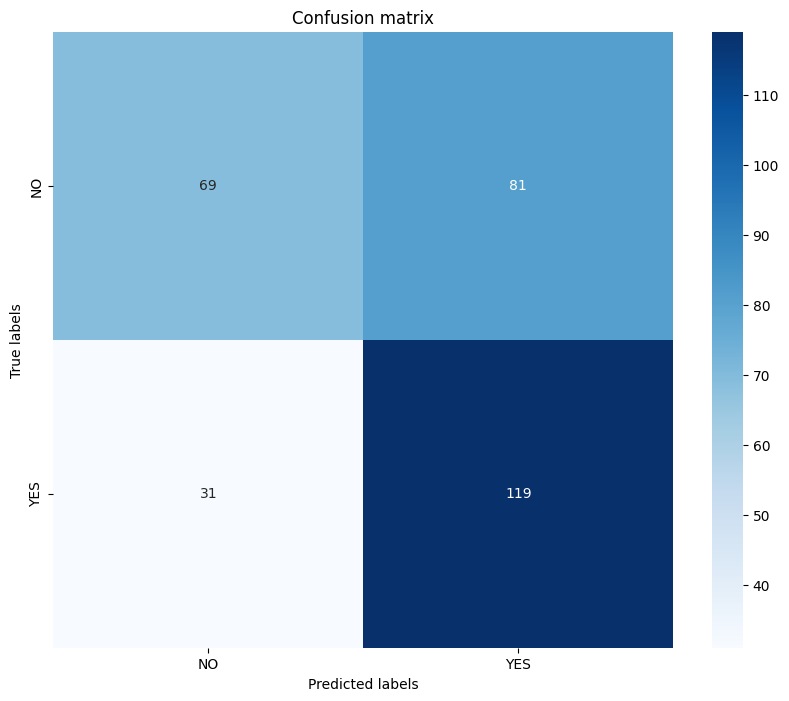

In [31]:
casted_predictions = df['predictions_phi_fs6'].apply(lambda x: 0 if x == -1 else x)
conf_matrix = confusion_matrix(y_true=y_true, y_pred=casted_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

Unexpectedly, the accuracy is lower than before. This could be due to the fact that the model is overfitting on the examples provided, and it is not able to generalize well on the test set. However, the performances are still way higher than the zero-shot case. 

We can then conclude that we need to find the right balance between the number of examples provided and the model's generalization capabilities.

---

# LLama v3.2 3B

The second model we use is `meta-llama/Llama-3.2-3B-Instruct`. This model has 3B parameters and is a model for text generation and completion. We are using the v3.2 version, which is on the latest version of the model. Having fewer parameters than the previous model, we can expect it to be faster and more efficient, but with a lower performance.

### Huggingface Login

We need to login to Huggingface with another token to use the second model.

In [ ]:
token = "INSERT_TOKEN"
login(token)

In [33]:
model_card = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_card)
tokenizer.pad_token = tokenizer.eos_token

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

Now we build the model pipeline. First of all we define the quantization configuration for the model.

In [34]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

We can load the model from Huggingface.

In [35]:
model = AutoModelForCausalLM.from_pretrained(
    model_card,
    return_dict=True,
    quantization_config=bnb_config
)

model.to('cuda')

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e

Then, we can define the generation configuration for the model.

In [36]:
generation_config = model.generation_config
generation_config.max_new_tokens = 2
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.do_sample = False
generation_config.temperature = None
generation_config.top_p = None

We check if the quantized model fits into the GPU memory.

In [37]:
gpu_name = torch.cuda.get_device_name(0)
print(f"GPU: {gpu_name}")

total_memory = torch.cuda.get_device_properties(0).total_memory
print(f"Total GPU memory: {total_memory / (1024 ** 3):.2f} GB")

allocated_memory = torch.cuda.memory_allocated(0)
print(f"Allocated GPU memory: {allocated_memory / (1024 ** 3):.2f} GB")

GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Total GPU memory: 8.00 GB
Allocated GPU memory: 4.21 GB


We use the same prompt template for zero-shot inference as before.

In [38]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

We use Hugging Face custom handling function on the prompt to create our final template. For this model, we set `add_generation_prompt` to `False` in order to add a token that indicates the start of a response generation. Moreover, we set `continue_final_message` to `True`. We make this choice because (differenly from the previous model) this model also generates the roles of the chat (e.g. "system:", "assistant"), thus causing the extraction of the response to be more complex.

Note: the behaviour of the model is caused by how the tokenizer handles the prompt template.

In [39]:
prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=False, continue_final_message=True)

All the functions defined for the first model can be used for this model as well, with the exception of the `process_response` function, which needs to be redefined.

In particular, we want to split the response by whitespaces, and not by newlines, as the model generates the response in a single line.

In [40]:
def process_response(response):
    """
      This function takes a textual response generated by the LLM
      and processes it to map the response to a binary label.

      Inputs:
        response: generated response from LLM

      Outputs:
        parsed binary response: return 1 if YES and 0 if NO
    """
    result = response.split(" ")[-1].lower()
    if "yes" in result:
        return 1
    elif "no" in result:
        return 0
    else:
        return -1 # Invalid response, it will then casted to 0 for accuracy calculation. It is used for the fail rate calculation.

We can now run the inference loop on the dataset.

In [41]:
predictions = run_inference(df, model, prompt, tokenizer)
df['predictions_llama_zs'] = predictions

Tokenized prompts generated.
Responses generated.
Predictions generated.


We now compute the metrics for the zero-shot inference of LLama.

In [42]:
metrics_llama_zs = compute_metrics(df['predictions_llama_zs'], y_true)
print(metrics_llama_zs)

{'accuracy': 0.5133, 'fail_ratio': 0.8533}


The fail ratio is very high, causing a low accuracy. This is due to the fact that the model does not have information about how to generate the correct response (i.e. it does not know that it has to answer just `YES` or `NO` right after the end of the input). 

This difference between the two models is probably due to the different training data and fine-tuning process, but also due to the different sizes. Further analysis will be discussed in the error analysis section.

We can print the confusion matrix to see the distribution of the responses.

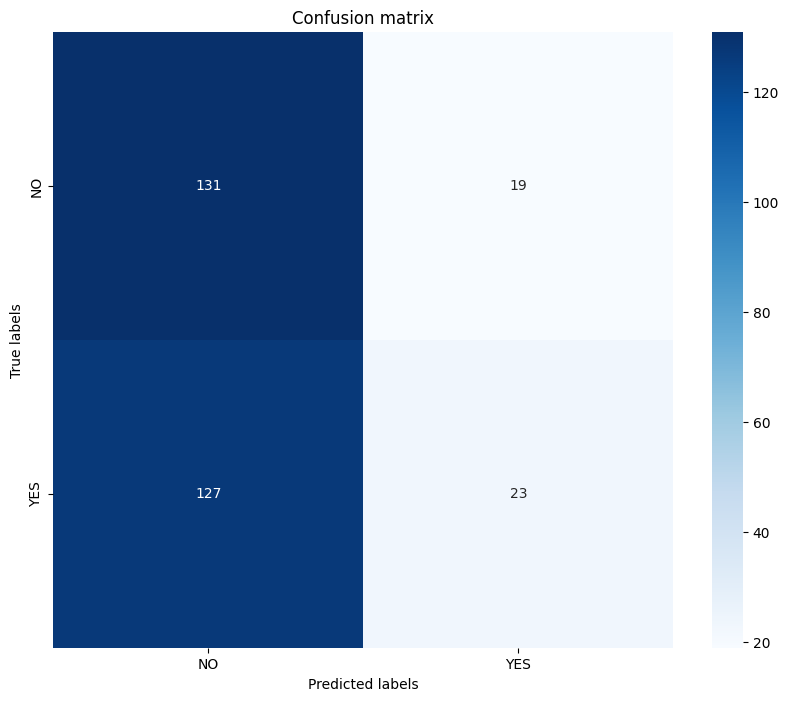

In [43]:
casted_predictions = df['predictions_llama_zs'].apply(lambda x: 0 if x == -1 else x)
conf_matrix = confusion_matrix(y_true=y_true, y_pred=casted_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

For the few-shot inference, we define again the prompt template.

In [44]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

We then run the inference loop on the dataset. We first start with 2 examples for each class.

In [45]:
num_per_class = 2
np.random.seed(42)

prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=False, continue_final_message=True)
predictions = run_inference_few_shots(df, model, prompt, tokenizer, num_per_class)
df['predictions_llama_fs2'] = predictions

metrics_llama_fs2 = compute_metrics(df['predictions_llama_fs2'], y_true)
print(metrics_llama_fs2)

Tokenized prompts generated.
Responses generated.
Predictions generated.
{'accuracy': 0.63, 'fail_ratio': 0.0133}


As we can see, the results are way better than the zero-shot case. This is mainly because the model understands that it must generate a `YES` or `NO` response right after the prompt.

We can print the confusion matrix to see the distribution of the responses.

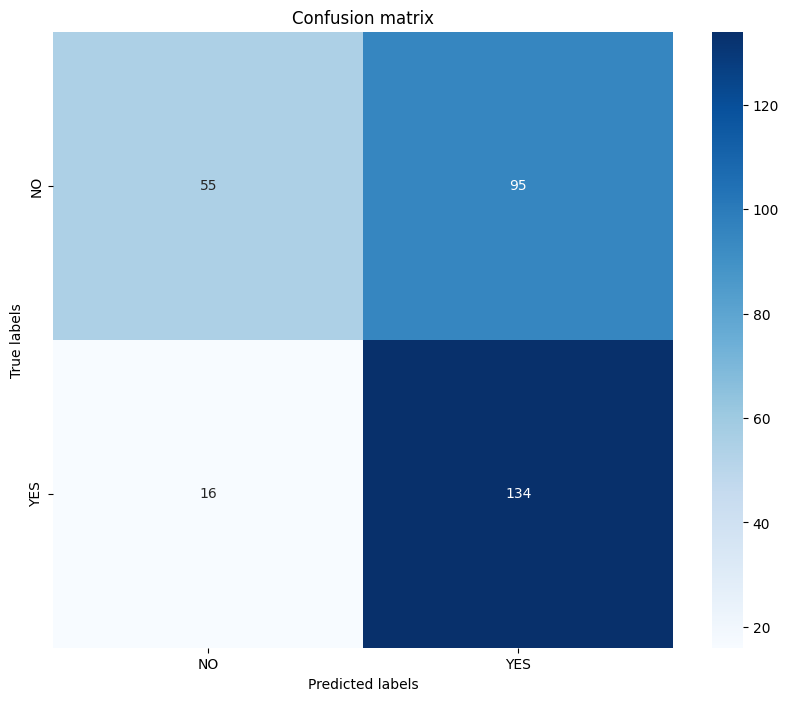

In [46]:
casted_predictions = df['predictions_llama_fs2'].apply(lambda x: 0 if x == -1 else x)
conf_matrix = confusion_matrix(y_true=y_true, y_pred=casted_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

We repeat the process using 4 examples for each class.

In [47]:
num_per_class = 4
np.random.seed(42)

predictions = run_inference_few_shots(df, model, prompt, tokenizer, num_per_class)
df['predictions_llama_fs4'] = predictions
metrics_llama_fs4 = compute_metrics(df['predictions_llama_fs4'], y_true)
print(metrics_llama_fs4)

Tokenized prompts generated.
Responses generated.
Predictions generated.
{'accuracy': 0.6333, 'fail_ratio': 0.0267}


The fail ratio slightly increases, but the accuracy is still high.

We print the confusion matrix.

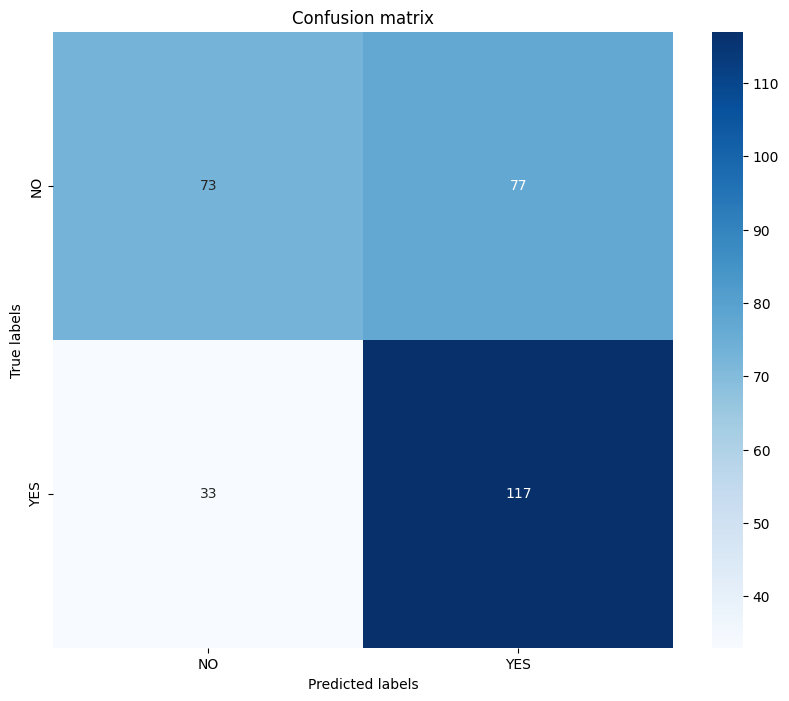

In [48]:
casted_predictions = df['predictions_llama_fs4'].apply(lambda x: 0 if x == -1 else x)
conf_matrix = confusion_matrix(y_true=y_true, y_pred=casted_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

We repeat the process using 6 examples for each class.

In [49]:
num_per_class = 6
np.random.seed(42)

predictions = run_inference_few_shots(df, model, prompt, tokenizer, num_per_class)
df['predictions_llama_fs6'] = predictions
metrics_llama_fs6 = compute_metrics(df['predictions_llama_fs6'], y_true)
print(metrics_llama_fs6)

Tokenized prompts generated.
Responses generated.
Predictions generated.
{'accuracy': 0.6067, 'fail_ratio': 0.0233}


We have basically the same results as before, with a slightly higher fail ratio. As we have seen with the previous model, we need to find the right balance between the number of examples provided and the model's generalization capabilities.

We print the confusion matrix.

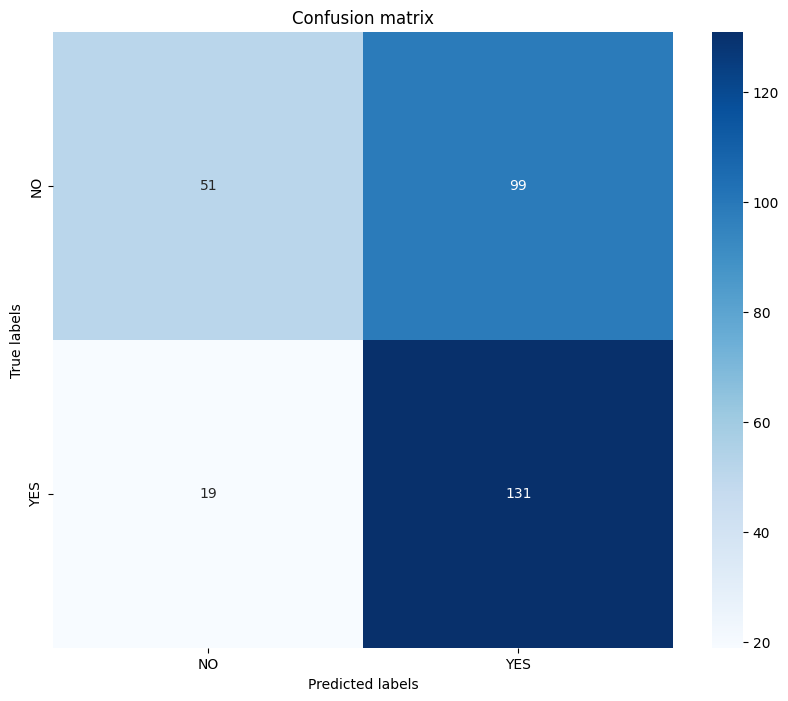

In [50]:
casted_predictions = df['predictions_llama_fs6'].apply(lambda x: 0 if x == -1 else x)
conf_matrix = confusion_matrix(y_true=y_true, y_pred=casted_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

For the error analysis, we create a dataframe with the accuracy and the fail ratio for each model and each number of examples provided.

In [51]:
results_phi_columns = ['accuracy_phi_zs', 'fail_ratio_phi_zs', 'accuracy_phi_fs2', 'fail_ratio_phi_fs2', 'accuracy_phi_fs4', 
                       'fail_ratio_phi_fs4', 'accuracy_phi_fs6', 'fail_ratio_phi_fs6']

results_llama_columns = ['accuracy_llama_zs', 'fail_ratio_llama_zs', 'accuracy_llama_fs2', 'fail_ratio_llama_fs2', 'accuracy_llama_fs4',
                            'fail_ratio_llama_fs4', 'accuracy_llama_fs6', 'fail_ratio_llama_fs6']

results_phi_df = pd.DataFrame(columns=results_phi_columns)
results_llama_df = pd.DataFrame(columns=results_llama_columns)

results_phi_df.loc[0] = [metrics_phi_zs['accuracy'], metrics_phi_zs['fail_ratio'], metrics_phi_fs2['accuracy'], metrics_phi_fs2['fail_ratio'],
                            metrics_phi_fs4['accuracy'], metrics_phi_fs4['fail_ratio'], metrics_phi_fs6['accuracy'], metrics_phi_fs6['fail_ratio']]
results_llama_df.loc[0] = [metrics_llama_zs['accuracy'], metrics_llama_zs['fail_ratio'], metrics_llama_fs2['accuracy'], metrics_llama_fs2['fail_ratio'],
                            metrics_llama_fs4['accuracy'], metrics_llama_fs4['fail_ratio'], metrics_llama_fs6['accuracy'], metrics_llama_fs6['fail_ratio']]

---

# [Task 6 - 1.0 points] Error Analysis

We are now interested in evaluating model responses and comparing their performance.

This analysis helps us in understanding

- Classification task performance gap: are the models good at this task?
- Generation quality: which kind of responses do models generate?
- Errors: which kind of mistakes do models do?

We display the results of the Phi model with the different configurations.

In [52]:
results_phi_df

,accuracy_phi_zs,fail_ratio_phi_zs,accuracy_phi_fs2,fail_ratio_phi_fs2,accuracy_phi_fs4,fail_ratio_phi_fs4,accuracy_phi_fs6,fail_ratio_phi_fs6
0,0.59,0.0,0.6467,0.0,0.6767,0.0,0.6267,0.0


As expected the accuracy increases with the number of examples provided, until we reach a plateau with 4 examples per class. We hypotesize that the decrease of the accuracy with 6 examples could be due to too many different examples offering a too broad context. The fail ratio is always 0, which means that the model is able to generate the correct response. Overall, the model performs well on the classification task.

We display the results of the Llama model with the different configurations.

In [53]:
results_llama_df

,accuracy_llama_zs,fail_ratio_llama_zs,accuracy_llama_fs2,fail_ratio_llama_fs2,accuracy_llama_fs4,fail_ratio_llama_fs4,accuracy_llama_fs6,fail_ratio_llama_fs6
0,0.5133,0.8533,0.63,0.0133,0.6333,0.0267,0.6067,0.0233


The model performs extremely badly with the zero-shots configuration, instead we have a significant improvement with the few-shots prompting.
As expected the accuracy increases with the number of examples provided, until we reach a plateau with 4 examples per class. We hypotesize that the decrease of the accuracy with 6 examples could be due to too many different examples offering a too broad context. In this case the fail ratio is not 0 but it is very low, which means that the model is able to generate the correct response. Overall, the model performs well on the classification task considering the low amount of the parameters.

We now want to understand the high fail ratio of the Llama model. We print the first 5 illegal responses generated by the model.

In [72]:
llama_zero_shot_errors=df[df['predictions_llama_zs'] == -1]
error_texts = []
for i in range(5):
    error_texts.append(llama_zero_shot_errors['text'].iloc[i])

In [74]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=False, continue_final_message=True)

tokenized_prompts = prepare_prompts(error_texts, prompt, tokenizer)
responses = generate_responses(model, tokenized_prompts)
for i in range(len(responses)):
    print("Input text: ", error_texts[i])
    print(responses[i].split(" ")[-1].lower())

Input text:  The boys must be gaming because there goes the wifi.
answer:
Input text:  Look at those eyes. Either someone unexpectedly just fisted her up the dumper, or that bitch is certifiably a nutburger.
answer:
Input text:  Old man mogs everyone in this sub
answer:
Input text:  So you run back to daddy whenever you need help. I thought men were sooo bad? Lol. Like I said at the end you need the help of men and can't do shit on your own. Your dad must be a major cuck to raise such a stupid daughter, what went wrong
answer:
Input text:  Don't think that using the word "feminine" wasn't strategic, Mo. It was. And I couldn't agree more with everything else you wrote. They attempt to bring the rest of us down to their level. Not gonna happen ... Lol, men are a gift from God.
answer:


As we can see the model does not answer anything in all cases shown. This could be caused by the tightness of the answer length we imposed. It seems that the model tends to insert spaces in the responses and for this reason they cause the model to reach the number of maximum tokens generated without actually addressing the task. This is a common problem with LLMs, as they tend to generate text that is not needed. This is why we have a fail ratio that is really high when we have no examples of correct answers.

For the few-shot case, we can see that the model is able to generate the correct response in most cases. This leads to a low fail ratio and a high accuracy, since the model has more information about the structure of the response.

From the confusion matrices we can observe that the models tend to generate a significant amount of false positive results. This could be caused by the bias of the models, built to avoid certain types of behavior. In fact, the models are instructed to avoid certain topics and in-depth discussions on sexism in general. This could lead to an overreaction to certain types of words or phrases.

If we use an uncensored model we could have a better performance but that could lead to more false negatives, being not sensible towards certain phrases.

We are aware that the results are not near the optimal but we considered only models with a limited number of parameters, and it is significant the imporvement from 3B to 3.8B parameters. We expect that by using bigger models, like Llama-3.2-8B-Instruct, we could achieve better performances. Since there was no strict requirement on the number of parameters we preffered to use the smaller models to avoid some problems caused by the colab environment. For this reason we needed to work locally and we adapted to the hardwere we had available.

A possible improvement to this task could be the randomization of the examples provided to the model at each prediction, possibly selecting the most related with the text considered. This could be done by using some techniques to find related documents and phrases (e.g. BM25, LDA, etc.). This could lead to a better generalization of the model and a better performance on the test set.

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# The End